In [1]:
from nht.models.NHT import NHT
from nht.utils import load_interface
import torch

/home/kerrick/miniconda3/envs/spinningup/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check L continuity of NN

In [2]:
# utils

def sample_uniform_vec(low, high, shape):
    return torch.rand(shape[0],shape[1])*(high-low)+low

def sample_vec_batch(batch, MLP_out_dim, scale):
    return sample_uniform_vec(-scale,scale,[batch,MLP_out_dim])

In [3]:
def empirical_Lipschitz_test(n_samples, input_shape, input_scale, func, output_mat=True):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
        vec2 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)

        # get norm of difference
        input_diff_norm = torch.linalg.norm(vec2-vec1, dim=-1, ord=2)

        # pass through func
        with torch.no_grad():
            out1 = func(vec1)
            out2 = func(vec2)

        if output_mat:
            output_diff_norm = torch.linalg.norm(out2-out1, dim=(-2,-1), ord=2)
        else:
            output_diff_norm = torch.linalg.norm(out2-out1, dim=-1, ord=2)

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

In [7]:
model_path = '/home/kerrick/uAlberta/projects/NHT/.results/test/NHT/20/version_0'
model_type = 'NHT'
Q = load_interface(model_type, model_path)

/home/kerrick/uAlberta/projects/NHT/.results/test/NHT/20/version_0/checkpoints/
['/home/kerrick/uAlberta/projects/NHT/.results/test/NHT/20/version_0/checkpoints/model-epoch=09-val_loss=0.046838.ckpt', '/home/kerrick/uAlberta/projects/NHT/.results/test/NHT/20/version_0/checkpoints/model-epoch=08-val_loss=0.046715.ckpt', '/home/kerrick/uAlberta/projects/NHT/.results/test/NHT/20/version_0/checkpoints/model-epoch=06-val_loss=0.046912.ckpt']
NHT
multihead: False
NHT(
  (h): MLP(
    (net): Sequential(
      (0): Linear(in_features=17, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=10, bias=True)
      (7): batch_ExpMap_sphere()
    )
  )
  (loss_fn): MSELoss()
)


In [5]:
for name, param in Q.h.named_parameters():
    if 'weight' in name:
        print(name)
        with torch.no_grad():
            print(torch.norm(param.data, p=2))

heads.0.weight
tensor(1.4953)
heads.1.weight
tensor(1.4953)
net.0.weight
tensor(1.4953)
net.2.weight
tensor(1.4953)
net.4.weight
tensor(1.4953)


In [ ]:
import numpy as np
(0.7071**3)*2*np.sqrt(2)

tensor([0.3349])
tensor([0.0689])


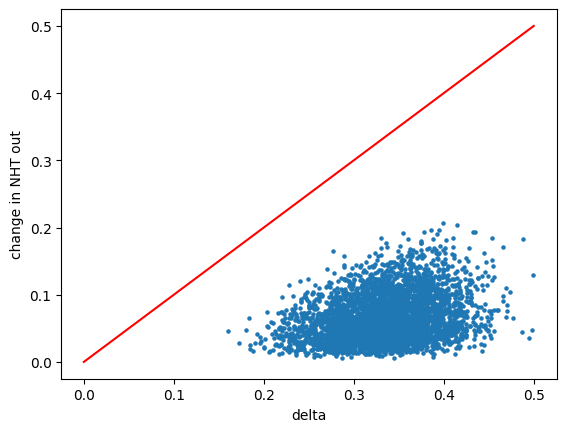

In [8]:
import matplotlib.pyplot as plt
import numpy as np


L_NHT = 1
n_samples = 4000

BATCH_SIZE = 1
k = 2
n = 6
c_dim=17 

input_shape = [BATCH_SIZE, c_dim]

input_scale = 0.1

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, Q)   

print(input_diff_norms[0])
print(output_diff_norms[0])

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in NHT out')

x = np.linspace(0,input_scale*5,500)
y = L_NHT*x

plt.plot(x,y, color='r')
#plt.ylim([0,2])
plt.show()

In [ ]:
from nht.models.MLP import ExpMap_sphere


In [ ]:
vec1 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
vec2 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)

# get norm of difference
input_diff_norm = torch.linalg.norm(vec2-vec1, dim=-1, ord=2)

# pass through func
with torch.no_grad():
    out1 = Q(vec1)
    out2 = Q(vec2)



In [ ]:
print(out1)
print(out1.shape)
print(torch.linalg.norm(out1, dim=(-2,-1), ord=2))

In [ ]:
print(out2)
print(out2.shape)
print(torch.linalg.norm(out2, dim=(-2,-1), ord=2))

In [ ]:
diff_Q = out1-out2
print(diff_Q)
print(torch.linalg.norm(diff_Q, dim=(-2,-1), ord=2))
print(torch.linalg.norm(diff_Q[0,:,:], ord=2))

In [ ]:
for name, param in Q.h.named_parameters():
    if 'weight' in name:
        with torch.no_grad():
            print(torch.norm(param.data, p=2))

In [ ]:
print((1.3712**4)*2*np.sqrt(2))

In [ ]:
input_shape = [BATCH_SIZE, c_dim]
vec1 = sample_vec_batch(input_shape[0], input_shape[1], 1.0)
print(vec1.shape)
print(torch.linalg.norm(vec1, dim=-1, ord=2))

In [ ]:
from nht.utils import get_model

k = 2
n = 6
c_dim=17 

new_NHT = get_model(None, u_dim=n, a_dim=k, c_dim=c_dim, hiddens=[64,64], activation='relu', lr=0.001, model='NHT')

In [ ]:
for name, param in new_NHT.h.named_parameters():
    if 'weight' in name:
        with torch.no_grad():
            print(torch.norm(param.data, p=2))

In [ ]:
import numpy as np

L_NHT = 1
n_layers = len([64,64])+1
L_NN = L_NHT/(2*np.sqrt(k)) # Correct for Lipschitz constant of householder transform
L_layer = np.power(L_NN, 1/n_layers)
print(L_layer)


In [ ]:
for name, param in new_NHT.h.named_parameters():
    if 'weight' in name:
        with torch.no_grad():
            rescale_factor = torch.norm(param.data, p=2) / L_layer
            param.data = param.data /  max(1, rescale_factor)

In [ ]:
for name, param in new_NHT.h.named_parameters():
    if 'weight' in name:
        with torch.no_grad():
            print(torch.norm(param.data, p=2))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


L_NHT = 1
n_samples = 4000

BATCH_SIZE = 1
k = 2
n = 6
c_dim=17 

input_shape = [BATCH_SIZE, c_dim]

input_scale = 0.1

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, new_NHT)   

print(input_diff_norms[0])
print(output_diff_norms[0])

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in NHT out')

x = np.linspace(0,input_scale*5,500)
y = L_NHT*x

plt.plot(x,y, color='r')
plt.show()